# Basic Machine Learning with Scikit-Learn

In this notebook we will look into the basics of building ML models with Scikit-Learn. Scikit-Learn is the most widely used Python libray for ML, especially outside of deep learning (where there are several contenders and I recommend using Keras, which is a package that provides a simple API on top of several underlying contenders like TensorFlow and PyTorch). Once again, this notebook draw heavily on Jake Vanderplas's excellent Python Data Science handbook.

We'll proceed in this fashion:

- give a brief overview of key terminology
- illustrate the typical use of SciKit-Learn API through some simple examples
- discuss various metrics that can be used to evaluate ML models
- dive deeper with some more complex examples
- look at the various ways we can validate and improve our models
- discuss the topic of feature engineering - ML models are good examples of "garbage in, garbage out", so cleaning our data and getting the right features is important
- finally, summarize some of the main model techniques and their pros and cons


## ML Terminology

*Machine Learning* can be considered the process of building models from data, either to gain insight into the data or to make predictions from the data. There are two main categories:

- *supervised learning*, in which the data is labelled with an outcome, and the aim is to predict new outcomes from new data; in the case where the outcome is a category this is called *classification* while if the outcome is a continuous quantity this is *regression*
- *unsupervised learning* where the data is analyzed for some underlying patterns to gain insight; common examples are *clustering* (finding similar cases) and *dimensionality reduction* (reducing the number of variables needed to represent the data, essentially a form of lossy compression)

The data used in ML is typically tabular. The columns are called *features*. For supervised learning, we call the  output the *label*. We'll often refer to the vector if features as X and the output (label) as y, and say that we're trying to find a function that approximates f(X)=y; this function is our *model* and is characterized by some *model parameters*. We usually choose the type or class of model, and then use ML techniques to learn the model parameters that minimize the *error* (the difference between the predicted and actual output). More generally we can think of this as an optimization problem, where we are trying to learn the parameters that minimize a *loss function*; that loss function is typically going to be some cummulative function of the errors; a common loss function is RMSE (root mean square of errors).

While we learn the model parameters, there are some parameters we need to specify as inputs to the model too; these are called *hyperparameters*. For example, if we learn a decision tree model, the parameters might be the features being tested at each branch and the values they are being tested against, while the hyperparameters would include the depth that we want to limit the tree to. For a polynomial regression model, the parameters would be the coefficients of the polynomial, while the hyperparameters could include the degree of polynomial we want to learn.

In this notebook we are going to focus on practical ML. We will not be going into the details of the various algorithms. We're also going to avoid the topics of *Deep Learning* and *neural nets*: these are generating a lot of hype at present but in general involve learning thousands of parameters requiring massive amounts of data for training (and a lot of time) and so are more limited in the domains in which they can be applied. The techniques we are going to look at can be used for much smaller problems and are generally very fast.

> It's worth noting that getting good data and the right features is generally more important than the type of model 
> you choose to use. The performance of the different types of ML model techniques is often similar. It's commonly
> said in ML circles that 80% of time is spent on getting data cleaned up and doing *feature engineering* and only 20%
> is spent on modeling. For example, until around 2014 when deep learning started taking off, most ML models at Google 
> were trained using the same system (Sibyl), a form of boosted logistic regression.


## Exploring the Iris Dataset

We would usually start with some exploratory analysis of the data. A very common approach if the number of features is not too high is to use a *pairplot* or *scatter matrix*. We'll use the famous Iris dataset in this example. We'll eventually be trying to predict the species, so it will be a focus even in our initial exploratory work:

In [ ]:
%matplotlib inline

In [ ]:
import seaborn as sns

iris = sns.load_dataset('iris')
iris.head()

In [ ]:
sns.set()
sns.pairplot(iris, hue='species', size=1.5);

In the pairplot, we're looking for several things: 

- are there features that are strongly correlated (or strongly inversely correlated)? If so, we may want to exclude one of the features, to simplify the model;
- are there obvious clusters, that may be linearly separable? If so we may get far with simple linear models (as opposed to more complex models like decision trees).
- are there features which seem correlated but our intuition or domain knowledge tells us should not be? In this case we may be missing features that are important to the model (these are called *confounding variables*)

For an example, we may see a correlation between daily ice cream consumption and drive-by shooting rates. We shouldn't expect this. It may be that the confounding variable is weather - in hotter weather people are more likely to be outside, resulting in an increase in both ice cream consumption and drive-by shootings.

If we are looking at classification, we should aim to have a dataset that is balanced in the number of observations of each category. We can check this with:

In [ ]:
print(iris.groupby('species').size())

If the dataset is not balanced we may want to resample it, over-sampling from items from less common classes or undersampling from items with more common classes.

It's worth paying attention to the histograms on the diagonal of the scatter plot. Some modeling techniques work best when these features have Gaussian distributions. Another way of looking at these is with density plots:

In [ ]:
import matplotlib.pyplot as plt
iris.plot(kind='density', subplots=True, sharex=False)
plt.show()

If the distributions are not Gaussian, we may want to normalize them with a Box Cox transformation. That is beyond the scope of this notebook; Google it if you need it. Some ML models depend on the inputs being Gaussian; e.g. logistic regression, and Linear Discriminant Analysis (LDA).

## A Simple Classification Model to Predict the Species

In practice, we would usually store the data in the form of a Pandas DataFrame or NumPy array, the *features matrix*, and assign it to a variable `X`. Lets get the data into the X/y form we need for training a model:

In [ ]:
X = iris.drop('species', axis=1)
X.head()

In [ ]:
y = iris['species'] 
y.head()

SciKit-Learn has a simple and consistent API that makes it easy to learn. After getting the data in the right form, the steps are just:

- import the model type
- instantiate the model with the appropriate *hyperparameters*
- call the `fit()` API to learn the model parameters
- call `predict()` to predict the results for new data

We want to test our model on new data; the typical way to do this is to split the data into a *training set* and a *testing set*; a common split is 80/20 or 75/25.


In [ ]:
from sklearn.model_selection import train_test_split
        
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1, test_size=0.2)


The first model type we will apply is Gaussian naive Bayes; this is simple and fast and needs no hyperparameters so it is a good baseline. It does work best if the inputs have Gaussian distributions but we'll ignore that:

In [ ]:
from sklearn.naive_bayes import GaussianNB
        
model = GaussianNB()
model.fit(Xtrain, ytrain)

In [ ]:
ypredict = model.predict(Xtest)
ypredict

To evaluate the model we want to know the accuracy:

In [ ]:
from sklearn.metrics import accuracy_score
        
accuracy_score(ytest, ypredict)

So even a naive model is 97% accurate on this data.

Let's look at a different model, so you can see how easy it is to switch between different approaches. We'll try a decision tree model:

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=4)
model.fit(Xtrain, ytrain)
ypredict = model.predict(Xtest)
accuracy_score(ytest, ypredict)

Another way to see how well we have done is to use a *confusion matrix*:

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 

mat = confusion_matrix(ytest, ypredict)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

We can see from the above that we got 29 predictions right, and only one wrong.

Confusion matrices are particularly useful for binary classifiers (only two output states), where we can clearly see the number of false positives and false negatives.

## Unsupervised Learning - Dimensionality Reduction with PCA on Iris Dataset

We'll now look at an example of unsupervised learning, doing Principal Component Analysis to do dimensionality reduction on the dataset so we can reduce to two dimensions for visualization.


In [ ]:
from sklearn.decomposition import PCA 

model = PCA(n_components=2) # Reduce to two features/dimensions
model.fit(X)  # No need to specify y for unsupervised.
X_2D = model.transform(X) 
# See the first few entries
X_2D[:5]

In [ ]:
# Lets make a DataFrame and plot it.
import pandas as pd

df = pd.DataFrame(X_2D, columns=['PCA1', 'PCA2'])
df['species'] = y
df.head()

In [ ]:
sns.lmplot("PCA1", "PCA2", hue='species', data=df, fit_reg=False);

The interesting thing to note is how the species are well separated. But when we generated the PCA values we did not tell the model anything about the species! This means that we should be able to use the input features (or the PCA features) and generate a good classification model. 

## Unsupervised Learning - Clustering on Iris Dataset

Now let's look at clustering. We'll use k-means clustering:

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)
model.fit(X)
y_kmeans = model.predict(X)

We can see how well we have done by plotting each cluster separately. We'll use the PCA pseudo-features so we can still use 2D plots.

In [ ]:
df['cluster'] = y_kmeans
sns.lmplot('PCA1', 'PCA2', data=df, hue='species', col='cluster', fit_reg=False); 

It's clear we have done very well in clustering in the blue case, but a bit less well with the other two species; this makes sense if you look at the earlier PCA plot, where you can see the blue species is more cleanly separated than the other two.

## Metrics for Evaluating Supervised Models

So far we have used classification accuracy, i.e. the percentage of correct predictions made, to evaluate models. This is really only suitable when there are an equal number of observations in each class (which is rarely the case) and that all predictions and prediction errors are equally important, which is often not the case. However, there are other metrics we can use. We'll briefly look at these here and then show how they can be used in the next couple of examples.

### Classification Metrics

### Logarithmic Loss

For multi-class classification where the model outputs a probability for each class we can use log-loss. This is commonly used in Kaggle competitions. It is defined as:

   $LL = - \frac{1}{N} \sum_{i=1}^N \sum_{j=1}^M y_{ij} \log \, p_{ij}$

where $N$ is the number of samples or instances, $M$ is the number of possible labels, $y_{ij}$ is a binary indicator of whether or not label $j$ is the correct classification for instance $i$, and $p_{ij}$ is the model probability of assigning label $j$ to instance $i$. 

Smaller logloss is better with 0 representing a perfect classification.

#### Classification Report

This shows precision, recall, and F1 score.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypredict))

- *Precision* or *positive predictive value (PPV)* is the ratio of correct classifications (true positives) to total classifications for the class (i.e. TP / (TP + FP), where TP is # of true positives and FP is number of false postives)

- *Recall* or *sensitivity* is the ratio of correct classifications to total instances of the class (i.e. TP / (TP + FN))

- *F1* is the harmonic mean of precision and recall.

You can read more about these measures here: https://en.wikipedia.org/wiki/Precision_and_recall

#### Area under ROC Curve

Area under ROC Curve (or AUC) represents a binary classifier’s ability to discriminate between positive and negative classes. An area of 1.0 represents a model that made all predictions perfectly. An area of 0.5 represents a model that is as good as random. ROC can be broken down into sensitivity (true positive rate/recall) and specificity (true negative rate), which are traded off.

We're not going to go into the details here; if you're interested there is a deep discussion here: http://mlwiki.org/index.php/ROC_Analysis

### Regression Metrics

#### Mean Absolute Error

This is just the sum of the absolute values of the prediction errors; i.e.:

   $MAE = \frac{\sum\limits_{i=1}^n |y_i - \hat{y_i}|}{n}$

where $y_i$ is the actual value for the $i$th sample and $\hat{y_i}$ is the predicted value.


#### Mean Squared Error

This is the mean value of the square of the errors:

   $MSE = \frac{\sum\limits_{i=1}^n (y_i - \hat{y_i})^2}{n}$

To reduce the size of the value we can take the square root at the end; this gives us the Root Mean Squared Error or RMSE.

#### $R^2$

$r^2$ is also known as the coefficient of determination and is 0 for no fit and 1 for a perfect fit. It is the proportion of the variation in the dependent variable that is predictable from the independent variable(s). See https://en.wikipedia.org/wiki/Coefficient_of_determination for more details.


## Model Validation

We've seen one way of doing model validation; namely, splitting the data into a training set and a test set. In this section we'll look at a more sophisticated approach, namely cross-validation. We'll also see how we can use run into the problem of overfitting the data, and discuss the two concepts of bias and variance, and how these are traded-off.

### Overfitting the Training Data

Imagine that for our model, we just hashed the input features to the output label. If we ran this as a model, and passed the same training data in as test data, we would get an exact match every time, suggesting we have a 100% accurate model! But if we gave the model new data it hadn't seen, it would fail dismally, not even being able to predicta result. We could address this by using some kind of fuzzy matching of hash keys, so at least we could get predictions out, but the result is likely to be a poor model. This illustrates two problems:

- we shouldn't test with our training data or we are likely to get an unreasonable expectation of accuracy
- the model may 'fit' the training data very well but not generalize well to new data; we call this 'overfitting'

On the other hand, if we split into test and training data (where the test data is what we call a 'holdout set'), we lose some of our training data. What to do? Fortunately, there is a way we can use all of our data for training *and* for testing, using *cross-validation*!

### Cross Validation

Let's say we split the data in half; call the two halves H1 and H2. We could train a model on H1 and test it on H2, and get an accuracy A1. We could train a second model on H2 and test it on H1, and get an accuracy of A2. This suggests that if we train a model using all the data, the accuracy when tested on new data should be somewhere between A1 and A2.

In practice, we don't split in half. More generally, we will split the data into k pieces of *folds*, $F_1$, $F_2$, ..., $F_k$, and then build $k$ models, where the $n$th model uses $F_n$ as the test set and the remaining pieces excluding $F_n$ as the training set. The $k$ individual scores are then combined ito a final score (mean and standard deviation). This is called *k-fold cross validation*. The size of each fold must  be large enough to be a reasonable sample of the problem, while allowing enough repetitions of the train-test evaluation of the algorithm to provide a fair estimate of the algorithms performance on new data. Commonly-used values for k are 5 or 10, although we can go all the way to the extreme where $k$ is the size of the training set; this is called *leave-one-out cross validation*.  It is computationally expensive and the results have high variance.

We can do k-fold cross-validation in SciKit-Learn easily with `cross_val_score`:

In [ ]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, cv=5)  # 5-fold; this will call model.fit() 5 times with different data
scores.mean()

### The Bias-Variance Trade-Off

What can we do if our model performs poorly? Assuming it is not just due to the data being random, in which case we may never be successful, we have several possible strategies:

- use a more complex model to get a better fit to training data (reduce bias, increase variance)
- use a simpler model because we may have overfit the training data (increase bias, reduce variance)
- get more data to train on
- add more features (we'll talk about this later)

There are two measures mentioned above, bias and variance. Without getting too much into the details, bias is a measure of error (how far off predictions are from reality) while variance can be thought of as how closely the model fits to noise. So a model with high bias underfits, while a model with high variance overfits, and we want to find the sweet spot between these (best fit). A model with high variance will do poorly on the validation set (as it overfits the training set), while a model with high bias should do about as well on the validation set as the training set (or about as bad!)

If we increased the complexity of our model, it would do better and better at fitting the training data, but at some point would start getting worse and worse at fitting the validation data. This is the *bias-variance trade-off*; you can see it in the image below where the vertical dashes line is the sweet spot we want to find.


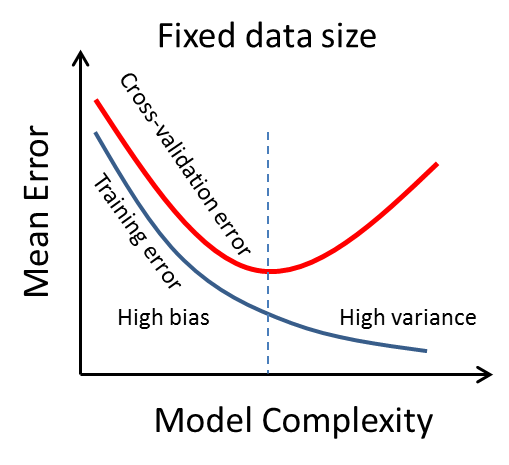

In [42]:
from IPython.display import Image
url = 'https://i.stack.imgur.com/S0tRm.png'
Image(url,width=400, height=400)

### Learning Curves

Note that the first two options we have, around model complexity, assume that the data is a fixed size. The third option is to add more data. As we add more data the optimal model will change. Assuming we capture the complexity of the data we are modelling, at some point we should have diminishing returns where adding more data doesn't significantly improve the model. This means that if we have a lot of data, it can be useful to meaure how well the model is doing as we are training it, so we can stop when we reach the point where the further improvements are negligible. If we plot the training and validation scores as a function of the size of the data set we get the *learning curve*.

We would expect that a model will overfit a small dataset and underfit a large dataset, where 'small' and 'large' are dependent on the complexity of the model. We would also expect in almost every case that the training score is better than the validation score(or equivalently the training error is lower than the validation error). So a typical learning curve will look like:

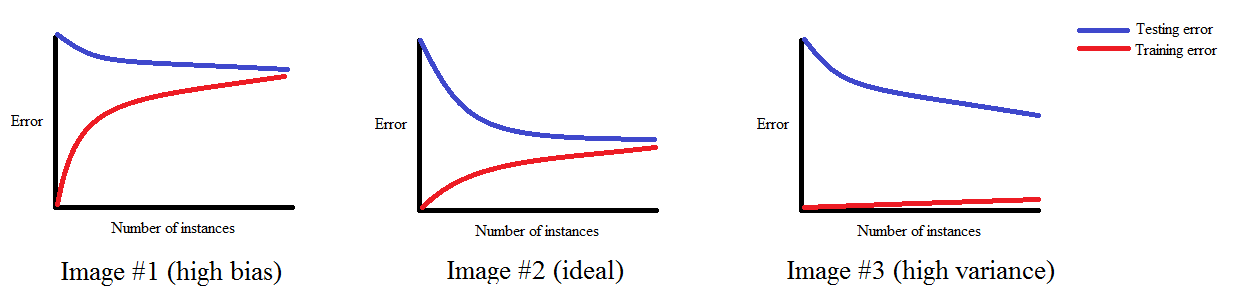

In [41]:
from IPython.display import Image
url = 'https://cdn-enterprise.discourse.org/udacity/uploads/default/original/3X/1/e/1e28f112574e48fea279ddf1b052c0d3e774f470.png'
Image(url,width=800, height=800)

Note that the curve converges to some score as the amount of data increases.

### Grid Search

Drawing plots of validation and learning curves can be useful except that in many cases models have multiple knobs (hyperparameters) to adjust; this makes using such visual aids more difficult. Instead, we can just train multiple versions of the model and have SciKit-Learn do the work, using a *grid search*.

To do this, we need to create a dictionary, where the keys are the different model constructor arguments, and the values are lists of values that we want to try. Then we can have SciKit-Learn find the best values for the parameters with cross-validation using `GridSearchCV`: 

    from sklearn.grid_search import GridSearchCV

    grid = GridSearchCV(model, param_dict, cv=10)
    grid.fit(X, y)
    print(grid.best_params_)
    
    final_model = grid.best_estimator_

It's also possible to use a list of dictionaries. SciKit-Learn will do an exhaustive search of the entire parameter space by default. `RandomizedSearchCV` can be used for a randomized search instead.

You can read more here: http://scikit-learn.org/stable/modules/grid_search.html

## Feature Engineering and Data Transforms

Apart from changing the model complexity and adding more data, the main other strategy we have for improving our models is to add more features. We may be able to get more data from the problem domain, but in many cases we don't have that option. All is not lost though, as we can use other sources of data for dependent features, as well as sometimes synthesize new features from the features we are given. We will look at this in this section, along with ways of transforming our data to be more usable by our models.

SciKit-Learn helps us out here too; it supports a rich set of data transforms. The general approach is: create a transform, *fit* it to the data, and then apply it to *transform* the data. When new data arrives the previously fit transform can be applied to that for consistency. For the training data fit and tranform can usually be combined into a call to `.fit_transform()`.

### Rescaling Data to a Min/Max Range

This can be done easily with:

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(0, 1))
    X2 = scaler.fit_transform(X)
    
It applies the transform $x' = \frac{x - min(\bf{x})}{max(\bf{x}) - min(\bf{x})}$.

Rescaling to [0, 1] is the most common use case.


### Standardizing Distributions

To convert a Gaussian-distributed value to have mean 0 and standard deviation 1 we use z-score normalization:

$x' = \frac{x - E(\bf{x})}{\sqrt{Var(\bf{x})}}$

where $E(\bf{x})$ is the expected value or mean of $\bf{x}$ and the standard deviation is the square root of the variance of $\bf{x}$.


    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler().fit(X)
    X2 = scaler.transform(X)

### Normalizing to Unit Length Vectors

Normalized data has each row/observation have length 1 when treated as an n-dimensional vector.


    from sklearn.preprocessing import Normalizer

    scaler = Normalizer().fit(X)
    X2 = scaler.transform(X)

### Binarizing/Thresholding

    from sklearn.preprocessing import Binarizer

    binarizer = Binarizer(threshold=0.0).fit(X)
    binaryX = binarizer.transform(X)

### Handling Categorical Data

Many ML algorithms rely on the inputs being numeric quantities. So how should we deal with categorical data? We could use a simple mapping of categories to numbers, but this is a bad idea, as the models assume that the values have some numerical significance.

A better approach is to use *1-hot encoding*. We saw this briefly in the Pandas notebook. The idea is to add a new column for every unique value of that categorical variable, and then encode the values in those columns as zeroes except for the column corresponding to the original value.

Here is a simple example:

In [ ]:
data = [
        {'color': 'red'},
        {'color': 'blue'},
        {'color': 'green'},
        {'color': 'blue'}
]

In [ ]:
from sklearn.feature_extraction import DictVectorizer

v = DictVectorizer(sparse=False, dtype=int)
v.fit_transform(data)  # We could use .transform() but would need to set a 'vocabulary'

In [ ]:
v.get_feature_names()

If we have a lot of different values for the category, this can add many columns, which may affect which modeling approaches we can use later. In this case you probably will want to set the `sparse` argument to `True` to save memory.

### Handling Text

For text, there are a few different options. Most commonly we will split the text up into a sequence of words. In many cases we will remove *stop words* (common words like 'and' and 'the'), and may perform operations such as 'stemming', 'named entity recognition', 'parts of speech tagging', etc. We're not going to go into these here; see the SpaCy NLP library for examples (https://spacy.io/).

We can use a similar approach to the categorical data, and turn each unique word into a new column. We can encode with 0/1 like one-hot, or use word counts. Let's look at the latter. In this case `fit_transform` returns a sparse array so we turn it back into a DataFrame:

In [ ]:
data = [
    "the cat sat on the mat",
    "the mat belonged to the rat",
    "the hat was on the mat",
    "the cat ate the rat",
    "the cat now has the hat"
]

from sklearn.feature_extraction.text import CountVectorizer

v = CountVectorizer()
X = v.fit_transform(data)
pd.DataFrame(X.toarray(), columns=v.get_feature_names())

The problem with word counts, especially if we don't remove stop words, is that common words get scored highly, which may not always be desirable. What we want to score highly are words that are common *in this row* that are not common *across all rows*. That should weight words that are significant to the particular row. We can do this with *Term Frequency - Inverse Document Frequency* or TF-IDF scores. In our small example this doesn't quite have the desired effect but the code is useful to show:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

v = TfidfVectorizer()
X = v.fit_transform(data)
pd.DataFrame(X.toarray(), columns=v.get_feature_names())

Read more about TF-IDF here: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

### Handling Missing Data

We saw a bit about handling missing data in the Pandas notebook. SciKit-Learn has some useful functionality to help us here too, namely the `Imputer`:

    from sklearn.preprocessing import Imputer
        
    X = Imputer(strategy='mean').fit_transform(X)

The above code will replace any `nan` values in the original array X with the mean of the non-nan values in that column. Other strategies are `median` and `most_frequent`.


### Synthesizing and Adding Features

In many cases, we will want to create features that are not directly available in the data, but are derived or synthesized from these. For example, the data may have city names, which we may want to turn into latitude/longitude, or perhaps include data like the population of the city. In such cases we would need to include the necessary tables to look up these features from the input features before fitting or predicting with the model.

Another common case is to improve the power of regression. Regression fits a line in 2D, or a plane in higher dimensions, but this is linear. What if a polynomial of higher order would be a much better fit? We can still use linear regression, all we need to do is add features that are higher-order powers of the input features!

Consider this data:

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y);
 

If we just use these features as is and fit a linear model we get this:

In [ ]:
from sklearn.linear_model import LinearRegression
        
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit);

Let's add some synthetic features that are higher-order powers of X:

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
        
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
X2 

Now we can fit a linear model to this extended set of features, and plot the results; you'll see we have a much better fit:

In [ ]:
model = LinearRegression().fit(X2, y)
        
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit); 

## Reducing Features

Sometimes the right thing to do is to reduce the number of features. For example, we may have performance constraints (memory/CPU) that mean we need to shrink the model. Or we may have extraneous features that aren't adding any value.

We've already seen one approach to this, namely PCA. There are other approaches too:

- we can use decision tree models to rank the importance of features:

In [ ]:
# Set up the Iris dataset again
X = iris.drop('species', axis=1)
y = iris['species']

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)

- we can use Recursive Feature Elimination (RFE) to recursively remove attributes and build a model based on those that remain, then use the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute. The example below uses logistic regression but any algorithm could be used:

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

- We can use a chi-squared test to select the features with the strongest relationships with the output. The code below selects the three best features:

In [ ]:
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

test = SelectKBest(score_func=chi2, k=3)
fit = test.fit(X, y)

np.set_printoptions(precision=3)
print(fit.scores_)

## Pipelines

Sometimes we need to chain computations in SciKit. For example, when we looked at adding polynomial synthetic features, we produced a transformed feature vector before applying the linear model. This is a common enough operation that there is a mechanism available for it, namely pipelines.

In that example, the code had a form similar to:

````python
X2 = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X)
model = LinearRegression().fit(X2, y)
yfit = model.predict(trainy)
````

To write this as a pipeline, we could use:

````python
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(degree=3, include_bias=False), LinearRegression())
model = pipeline.fit(X, y)
yfit = model.predict(trainy)
````

Pipelines can help avoid a common mistake of leaking information from the test data set into the training data set. E.g. if we scale all data to be in range [0..1] but include the test data when determining the scale factors, this could be problematic. By doing the scaling in a pipeline along with model fitting this is less likely to occur. 

A more advanced feature of pipelines is the FeatureUnion. This is beyond the scope of this notebook but worth knowing about. See http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html.

Using a regression model with polynomial synthetic features is a useful and common enough approach that we can define a utility function for this; we will use this later:

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs)) 

## A Classification Example - Breast Cancer

A description of this data is at http://scikit-learn.org/stable/datasets/index.html#datasets, section 5.14. The columns are mean, standard error, and "worst" values of the following ten features, making 30 features in all,
followed by the class (malignant or benign).

- radius (mean of distances from center to points on the perimeter)
- texture (standard deviation of gray-scale values)
- perimeter
- area
- smoothness (local variation in radius lengths)
- compactness (perimeter^2 / area - 1.0)
- concavity (severity of concave portions of the contour)
- concave points (number of concave portions of the contour)
- symmetry
- fractal dimension (“coastline approximation” - 1)

In [ ]:
from sklearn.datasets import load_breast_cancer

features = load_breast_cancer().feature_names
X, y = load_breast_cancer(return_X_y=True)
features

In [ ]:
y[:5]

In [ ]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=1, test_size=0.2)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(max_depth=8)
model.fit(Xtrain, ytrain)
ypredict = model.predict(Xtest)
accuracy_score(ytest, ypredict)

Let's see what the most important features are:

In [ ]:
from operator import itemgetter
sorted(list(zip(features, model.feature_importances_)), key=itemgetter(1), reverse=True)[:10]

## A Regression Example - Boston Housing Prices

A description of this data is at http://scikit-learn.org/stable/datasets/index.html#datasets, section 5.13. The columns are:

- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centres
- RAD index of accessibility to radial highways
- TAX full-value property-tax rate per \$10,000
- PTRATIO pupil-teacher ratio by town
- B $1000(B_k - 0.63)^2$ where $B_k$ is the proportion of blacks by town
- LSTAT \% lower status of the population
- MEDV Median value of owner-occupied homes in $1000’s

MEDV is usually the target when building models with this data.

In [ ]:
from sklearn.datasets import load_boston

features = load_boston().feature_names
X, y = load_boston(return_X_y=True)
features

Let's apply a polynomial regression model and see how the model validation changes as we use different degrees of polynomials:

In [ ]:
import numpy as np
from sklearn.learning_curve import validation_curve

degree = np.arange(0, 10)  # We'll try up to a 10th degree polynomial
train_score, val_score = validation_curve(PolynomialRegression(), X, y, 'polynomialfeatures__degree', degree, cv=7)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');

We can use grid search to find a good model; we can vary a couple of other hyperparameters too:

In [ ]:
from sklearn.grid_search import GridSearchCV

param_grid = {
    'polynomialfeatures__degree': np.arange(10),
    'linearregression__fit_intercept': [True, False],
    'linearregression__normalize': [True, False]
}

grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)
grid.fit(X, y)
grid.best_params_

## Combining Model Predictions with Ensembles

One way to improve performance is to combine the results of several models. There are several ways this can be done; for example:

* *Bagging* - building multiple models (typically of the same type) from different subsamples of the training dataset. Sampling is done with replacement, and the predictions are combined and averaged into a final result.
* *Boosting* - building multiple models (typically of the same type) each of which learns to fix the prediction errors of a prior model in the sequence of models.
* *Voting* - building multiple models (typically of differing types) and simple statistics (like calculating the mean) are used to combine predictions. *Stacking* is a voting approach which also learns the weights to give to each vote.

If we have a model type in `model`, we can do bagging with:

```python
from sklearn.ensemble import BaggingClassifier

model = ...
model = BaggingClassifier(base_estimator=model, n_estimators=50, random_state=0)
...
```

Random forests are another example of bagging. AdaBoost is a common example of a boosting algorithm.


## Interpreting Models

Once we have a good model, how do we interpret the results? That is, how can we justify the prediction when it is questioned?

For decision trees, this is not that difficult - the path through the decision tree illustrates the "reasoning" behind the decision. However, for many other models there is no intuitive interpretation. Getting a ranking of feature importance is helpful but not complete.

There has been some interesting work in this area for classification models. The approach is to rely on a form of sensitivity analysis - ask, "what small changes in the inputs would result in different outputs?". This can be done one a case by case basis, with the learnings often being generalizable to cover more cases.

This is really out of scope for this notebook, but if you are interested in learning more, the seminal work is LIME, which is described in this paper: https://arxiv.org/abs/1602.04938